# Project 2 Wrangling And Analyzing Data 

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Gather</a></li>
<li><a href="#assess">Assess</a></li>
<li><a href="#qissues">Data Quality Issues</a></li> 
<li><a href="#clean">Clean</a></li>
<li><a href="#storing">Storing</a></li>    
<li><a href="#analyzing">Analyzing, and visualizing Data</a></li> 
<li><a href="#reporting">Reporting</a></li>    
<li><a href="#conclusions">Conclusions And Recommendations</a></li>
</ul>

<a id='intro'></a>
## Introduction
* In this project we use real world data to gather, assess, and clean data, a process which is called Data Wrangling. We then apply analysis with visualizations to get insight from the data. 
* There are three pieces of data that will be gathered, assessed, cleaned, and then tranform into pandas Datafram in order to analyze.
* The project data was gotten from the Twitter account called ‘WeRateDogs’ (@dog_rates) which “rates people's dogs with a humorous comments about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc.” 
* The following are steps taken to achieve this project.

In [120]:
# Python libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import requests
import json
import os
import re
import warnings
warnings.simplefilter('ignore')
import tweepy
from timeit import default_timer as timer
import random
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image
import dataframe_image as dfi

<a id='gather'></a>

## Gather

In [121]:
# The WeRateDogs Twitter archive
# Using the pandas read_csv() we import the WeRateDogs Twitter archive data in pandas dataframe
twitter_archive_data = pd.read_csv('twitter-archive-enhanced.csv')

In [3]:
# The tweet image predictions data
# This data is programmatically downloaded from the Udacity servers and stored in a folder image_prediction, 
# We then written it to file in our computer and loaded into a pandas DataFrame.
folder_name = 'image_prediction'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
    
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
response = requests.get(url)

In [4]:
# Reading data to file
with open(os.path.join(folder_name, url.split('/')[-1]), mode = 'wb') as file:
    file.write(response.content)

In [5]:
df_image_prediction = pd.read_csv(folder_name +'/image-predictions.tsv', sep='\t')

In [6]:
#Second table tweet_count downloaded programmatically from twitter's API using tweepy, then saved 
# to a JSON file, stored in a dictionary, 
# then loaded into a pandas DataFrame.
# Using Twitter API to Query tweet count in the Twitter archive and save it as a JSON file

consumer_key = 'XBg7FTubuIpd4Tgksm5YqENev'
consumer_secret = '0MXoq8YmErK5x0eMTUXcXjUNKOck0QBgzokQNO6vWqurN1loTu'
access_token = '777789422-ljMVrsUiySoZaZLn3kaQrG6d1iNvvh1kT8NCftzg'
access_secret = 'CizYZZft1IvfWXx9ilqiTDNbs5WRMlAFdRljFAfZ15yqA'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

# Using Tweet IDs to gather additional data via Twitter's API
tweet_ids = twitter_archive_data.tweet_id.values
len(tweet_ids)

2356

In [7]:
# Using Code template provided by Udacity
# We define a function to extract tweet

def extract_tweet():
    count = 0
    fails_dict = {}
    start = timer()
    with open('tweet_json.txt', 'w') as outfile:
        for tweet_id in tweet_ids:
            count += 1
            print(str(count) + ": " + str(tweet_id))
            try:
                tweet = api.get_status(tweet_id, tweet_mode='extended')
                print("Success")
                json.dump(tweet._json, outfile)
                outfile.write('\n')
            except tweepy.errors.TweepyException as e:
                print("Fail")
                fails_dict[tweet_id] = e
                pass
    end = timer()
    print(end - start)
    print(fails_dict)
    
#extract_tweet()    


In [8]:
# We extract data from tweet_json.txt file
tweet_list = []
with open('tweet_json.txt', 'r', encoding = 'utf8') as tweet_file:
    for file in tweet_file:
        files = json.loads(file)
        tweet_list.append({'tweet_id': files['id'],
                        'favorites': files['favorite_count'],
                        'retweets': files['retweet_count'],
                        'timestamp': files['created_at']})
        
tweet_df = pd.DataFrame(tweet_list, columns=['tweet_id','favorites','retweets']) 

In [9]:
# Writing json file to pandas
tweet_count_df = pd.read_json('tweet_json.txt', lines=True)

<a id='assess'></a>
## Assess
* Programmatically Visualization

We first look at the visualization of the Twitter Archive data.

In [10]:
twitter_archive_data.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [11]:
twitter_archive_data.text.sample(10)

310     RT @dog_rates: So this just changed my life. 1...
957     This is Max. She has one ear that's always sli...
961     This is Cooper. He's just so damn happy. 10/10...
94      This is Sebastian. He can't see all the colors...
1712    Here we have uncovered an entire battalion of ...
1308    This is Cassie. She can go from sweet to scary...
739     Meet Hercules. He can have whatever he wants f...
305     This is Lucy. She spent all morning overseeing...
304     This is Ava. She just blasted off. Streamline ...
1846    🎶 HELLO FROM THE OTHER SIIIIIIIIDE 🎶 10/10s ht...
Name: text, dtype: object

In [12]:
twitter_archive_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [13]:
twitter_archive_data.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
twitter_archive_data.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [15]:
twitter_archive_data["doggo"].value_counts() 

None     2259
doggo      97
Name: doggo, dtype: int64

In [16]:
twitter_archive_data["floofer"].value_counts() 

None       2346
floofer      10
Name: floofer, dtype: int64

In [17]:
twitter_archive_data["pupper"].value_counts() 

None      2099
pupper     257
Name: pupper, dtype: int64

In [18]:
twitter_archive_data["puppo"].value_counts() 

None     2326
puppo      30
Name: puppo, dtype: int64

In [19]:
twitter_archive_data["name"].value_counts()

None         745
a             55
Charlie       12
Cooper        11
Oliver        11
            ... 
Eriq           1
Brandi         1
Timber         1
Suki           1
Sojourner      1
Name: name, Length: 957, dtype: int64

In [20]:
twitter_archive_data.rating_numerator.sort_values()

315        0
1016       0
2335       1
2261       1
2338       1
        ... 
2074     420
188      420
189      666
313      960
979     1776
Name: rating_numerator, Length: 2356, dtype: int64

In [21]:
twitter_archive_data.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

Next we assess the data gathere from the url programatically and saved in tweet_json.txt.

In [22]:
tweet_df.head()

,tweet_id,favorites,retweets
0,892420643555336193,33698,6970
1,892177421306343426,29228,5273
2,891815181378084864,21976,3464
3,891689557279858688,36793,7193
4,891327558926688256,35184,7718


In [23]:
tweet_df.tail()

,tweet_id,favorites,retweets
2322,666049248165822465,88,36
2323,666044226329800704,246,115
2324,666033412701032449,100,36
2325,666029285002620928,112,39
2326,666020888022790149,2283,419


In [24]:
tweet_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2327 entries, 0 to 2326
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   tweet_id   2327 non-null   int64
 1   favorites  2327 non-null   int64
 2   retweets   2327 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


In [25]:
tweet_df.describe()

,tweet_id,favorites,retweets
count,2.327000e+03,2327.000000,2327.000000
mean,7.417930e+17,7027.839708,2459.109153
std,6.820795e+16,10921.377442,4164.576611
min,6.660209e+17,0.000000,1.000000
25%,6.781394e+17,1221.500000,492.500000
50%,7.178418e+17,3036.000000,1144.000000
75%,7.986547e+17,8565.000000,2845.000000
max,8.924206e+17,144273.000000,70344.000000


In [26]:
tweet_df.shape

(2327, 3)

In [27]:
tweet_df["tweet_id"].value_counts()

749075273010798592    1
671163268581498880    1
798644042770751489    1
825120256414846976    1
769212283578875904    1
                     ..
794926597468000259    1
673705679337693185    1
673342308415348736    1
754482103782404096    1
700151421916807169    1
Name: tweet_id, Length: 2327, dtype: int64

In [28]:
tweet_df.isnull().sum()

tweet_id     0
favorites    0
retweets     0
dtype: int64

Lastly, we assess the image predictions dataset

In [29]:
df_image_prediction.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [30]:
df_image_prediction.tail()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True
2074,892420643555336193,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False


In [31]:
df_image_prediction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [32]:
df_image_prediction.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [33]:
df_image_prediction.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

<a id='qissues'></a>
### Data Quality Issues
> Following the assessment, we discover several issues with our data which we will describe below and come up with appropraite ways of cleaning the data.

> In the twitter archive data we discover that:
* 1. Since Project Motivation indicated that we only want original ratings (no retweets) that have images.We Remove the rows with retweets
* 2. Drop unnecessary columns in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_timestamp, and expanded_urls. 
* 3. Not all denominators are exactly 10, scale each numorator so the denominator is 10 for better comparison.
* 4. Missing values and messy names in column name  
* 5. There should have been a column for type or stages of dogs so that doggo, floofer, pupper and puppo can be accomodated in
* 6. Data type issues were noticed in twitter_id and datetime columns-which also have extra 0000 that need to be remove
* 7. Check in the text column to determine dog sex
* 8. Source column look messy andv clumsy, should be remove as it wont be necessary for analysis
> In the twitter image prediction data we discover that:
* 1. Columns p1, p2, and p3 consists of a mixture of uppercases and lowercases in the values

> Looking at the twitter count data (tweet_df) we discover that:
* 1. The twitter archive  and twitter count data looks similar, this should be merged
* 2. Column id_str should be changed to tweet_id and convert to object to enable us merge tables.



### Tidiness Issues
* Inaccurate Data Type for tweet_id and Datetime columns
* Inappropraite column name for Column id_str in the tweet_df dataset

<a id='clean'></a>
## Clean

#### Define

##### Twitter Archive Data Set
- Remove the rows with retweets using python isnull() function. 
- Select and drop all columns with missing values that is ( in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_timestamp, and expanded_urls.)
- Scale rating_numerator to 10.
- Rename column to rating_numerator to rating and change data type to float.
- Check for inappropriate dog name and change to NaN
- Create a column for doggo, floofer, pupper and puppo and change data type to categorical
- Change data type for twitter_id from (int64 ) to object using the astype() function and datetime from (object) to datetime using pandas to_datetime() function.
- Use str.strip() to remove extra 0000 from datetime
- Determing dog sex using code to check for she and he pronoun

##### Twitter image prediction data set
- Using str.lower() we convert all columns to lowercase
- Change tweet_id type from int to object

##### Twitter count data set
Using pandas rename function we change Column id_str should be changed to tweet_id and convert to object

#### Code

In [157]:
# To start our cleaning propper, we make copies of the dataframes 
#so that we can go back to the original copy if something goes wrong

twitter_archive_clean = twitter_archive_data.copy()
df_tweet_clean = tweet_df.copy()
image_prediction_clean = df_image_prediction.copy()

* Define
> Remove the rows with retweets using python isnull() function to keep only original ratings.

* Code

In [158]:
# Looking in the retweeted_status_user_id column for retweet rows to be removed
retweet_rows = twitter_archive_clean.retweeted_status_user_id.isnull().sum()
retweet_rows

2175

In [159]:
# As seen above there are 2175 retweet rows
# We again apply the isnull() to remove them
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.retweeted_status_id.isnull()]

* Test

In [160]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2175 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2175 non-null   object 
 4   source                      2175 non-null   object 
 5   text                        2175 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2117 non-null   object 
 10  rating_numerator            2175 non-null   int64  
 11  rating_denominator          2175 non-null   int64  
 12  name                        2175 non-null   object 
 13  doggo                       2175 

In [161]:
# We also check for reply to reweets
reply_to_retweet = twitter_archive_clean.in_reply_to_status_id.isnull().sum()
reply_to_retweet

2097

In [162]:
# Removing reply to retweet
twitter_archive_clean = twitter_archive_clean[twitter_archive_clean.in_reply_to_status_id.isnull()]
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2097 non-null   int64  
 1   in_reply_to_status_id       0 non-null      float64
 2   in_reply_to_user_id         0 non-null      float64
 3   timestamp                   2097 non-null   object 
 4   source                      2097 non-null   object 
 5   text                        2097 non-null   object 
 6   retweeted_status_id         0 non-null      float64
 7   retweeted_status_user_id    0 non-null      float64
 8   retweeted_status_timestamp  0 non-null      object 
 9   expanded_urls               2094 non-null   object 
 10  rating_numerator            2097 non-null   int64  
 11  rating_denominator          2097 non-null   int64  
 12  name                        2097 non-null   object 
 13  doggo                       2097 

* Define
> Select and drop all unnecessary columns that is ( in_reply_to_status_id, in_reply_to_user_id, retweeted_status_id, retweeted_status_timestamp, and expanded_urls.)

* Code

In [163]:
#twitter_archive_clean.dropna(axis='columns', how='any', thresh=None, subset=None, inplace=True)
twitter_archive_clean.drop(['in_reply_to_status_id','in_reply_to_user_id','retweeted_status_id','retweeted_status_user_id', 'retweeted_status_timestamp','expanded_urls'], axis=1, inplace=True)

* Test

In [164]:
twitter_archive_clean

,tweet_id,timestamp,source,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,5,10,None,None,None,None,None
2352,666044226329800704,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,6,10,a,None,None,None,None
2353,666033412701032449,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,9,10,a,None,None,None,None
2354,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,7,10,a,None,None,None,None


In [165]:
# We now perform the .column function to check 
twitter_archive_clean.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [166]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   tweet_id            2097 non-null   int64 
 1   timestamp           2097 non-null   object
 2   source              2097 non-null   object
 3   text                2097 non-null   object
 4   rating_numerator    2097 non-null   int64 
 5   rating_denominator  2097 non-null   int64 
 6   name                2097 non-null   object
 7   doggo               2097 non-null   object
 8   floofer             2097 non-null   object
 9   pupper              2097 non-null   object
 10  puppo               2097 non-null   object
dtypes: int64(3), object(8)
memory usage: 196.6+ KB


* Define
> From the Project Motivation, we gathered that the fact that the rating numerators are greater than the denominators does not need to be cleaned. 
> This unique rating system is a big part of the popularity of WeRateDogs.
> Thus we scale each numorator so the denominator is 10
> Using the drop() we get rid of denominator 

* Code

In [168]:
# Check for rows where rating_denominator is not equal to 10
twitter_archive_clean[twitter_archive_clean.rating_denominator !=10].value_counts().sum()

17

In [171]:
twitter_archive_clean['rating_numerator'] = twitter_archive_clean.rating_numerator * \
(10/twitter_archive_clean.rating_denominator)


* Test

In [174]:
twitter_archive_clean.rating_numerator.value_counts()

12.000000      486
10.000000      436
11.000000      413
13.000000      287
9.000000       152
8.000000        98
7.000000        51
14.000000       38
5.000000        34
6.000000        32
3.000000        19
4.000000        15
2.000000         9
1.000000         4
0.480000         1
5.259204         1
69.970845        1
6.761833         1
0.360000         1
1776.000000      1
0.083333         1
0.041522         1
0.000000         1
27.000000        1
0.090909         1
0.400000         1
0.048889         1
420.000000       1
0.244898         1
0.500000         1
0.156250         1
0.687500         1
26.000000        1
75.000000        1
0.171875         1
0.135802         1
125.000000       1
Name: rating_numerator, dtype: int64

* Define
> Rename column rating_numerator to rating.
> Convert column data type to float

* Code

In [176]:
# we will rename rating_numerators column to rating for better analysis.
# Code below learnt from Source:https://stackoverflow.com/questions/59814872/error-when-renaming-and-dropping-columns-at-the-same-line-pandas-data-frame
rename_drop_col = twitter_archive_clean.rename(columns = {'rating_numerator':'rating'}, inplace = False).drop('rating_denominator',axis=1,inplace=False)

In [177]:
twitter_archive_clean = rename_drop_col

* Test

In [179]:
twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_id   2097 non-null   int64  
 1   timestamp  2097 non-null   object 
 2   source     2097 non-null   object 
 3   text       2097 non-null   object 
 4   rating     2097 non-null   float64
 5   name       2097 non-null   object 
 6   doggo      2097 non-null   object 
 7   floofer    2097 non-null   object 
 8   pupper     2097 non-null   object 
 9   puppo      2097 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 180.2+ KB


* Define
> Missing values and messy names in column name

* Code

In [180]:
# Fixing Messy names
twitter_archive_clean.name

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2351        None
2352           a
2353           a
2354           a
2355        None
Name: name, Length: 2097, dtype: object

In [181]:
# Let do a sample selection and see
name_list = list(twitter_archive_clean.name)
print(random.sample(name_list, 1000))

['Kingsley', 'None', 'Jeffrie', 'None', 'None', 'Bonaparte', 'Dexter', 'Rocky', 'Tucker', 'Sophie', 'Rusty', 'Phil', 'Cecil', 'Lilli', 'very', 'Malcolm', 'Milo', 'Lizzie', 'Jennifur', 'None', 'Zoey', 'None', 'the', 'Fiona', 'Kreg', 'Sandra', 'a', 'Brockly', 'Kevin', 'Stubert', 'Tassy', 'Atlas', 'quite', 'Napolean', 'Huxley', 'None', 'Blu', 'None', 'Ricky', 'Cash', 'Carper', 'Samson', 'Oakley', 'None', 'Juno', 'None', 'Billl', 'None', 'Axel', 'Bode', 'None', 'None', 'Obi', 'one', 'Walker', 'Maggie', 'None', 'Barney', 'Lugan', 'None', 'Oliver', 'None', 'Toby', 'Edmund', 'None', 'Charlie', 'Stephan', 'None', 'Schnozz', 'Lola', 'Daisy', 'Jim', 'Dudley', 'None', 'Benji', 'Wilson', 'Ash', 'Cooper', 'Sampson', 'Kawhi', 'Malcolm', 'None', 'None', 'Timmy', 'None', 'Abby', 'None', 'None', 'Nida', 'Rufio', 'a', 'Sweet', 'Oscar', 'Clark', 'Finn', 'None', 'None', 'Cupid', 'Tommy', 'None', 'Anakin', 'None', 'None', 'Calvin', 'Scout', 'Richie', 'None', 'Zuzu', 'Tanner', 'Dave', 'None', 'Liam', 'Sammy

In [182]:
# We can see that majority of names begin with uppercase letter
# Our assuption is that those names begining with lowercases are wrong
twitter_archive_clean.loc[(twitter_archive_clean.name.str.islower())].name.value_counts()

a               55
the              8
an               6
very             4
one              4
just             3
quite            3
getting          2
actually         2
not              2
light            1
old              1
incredibly       1
my               1
all              1
space            1
this             1
his              1
officially       1
mad              1
infuriating      1
such             1
life             1
unacceptable     1
by               1
Name: name, dtype: int64

In [183]:
# Let see how many of these names
twitter_archive_clean.loc[(twitter_archive_clean.name.str.islower())].name.value_counts().sum()

104

In [184]:
# To deal with this issue we shall replace these lowercase names with NaN then change all None to NaN
twitter_archive_clean.loc[twitter_archive_clean['name'] == twitter_archive_clean['name'].str.lower(), 'name'] = np.nan
print(twitter_archive_clean['name'])

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2351        None
2352         NaN
2353         NaN
2354         NaN
2355        None
Name: name, Length: 2097, dtype: object


* Test

In [185]:
# Let now replace Non to NaN
twitter_archive_clean['name'].replace(to_replace = 'None', value = np.nan, inplace = True)
print(twitter_archive_clean['name'])

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2351         NaN
2352         NaN
2353         NaN
2354         NaN
2355         NaN
Name: name, Length: 2097, dtype: object


* Define
> There should have been a column for type or stages of dogs so that doggo, floofer, pupper and puppo can be accomodated in

* Code

In [186]:
# As stated in the Define section above, we collapse doggo, floofer, pupper and puppo in one colunm
# Lets look at the text column in our twitter archive data set
twitter_archive_clean['text']

0       This is Phineas. He's a mystical boy. Only eve...
1       This is Tilly. She's just checking pup on you....
2       This is Archie. He is a rare Norwegian Pouncin...
3       This is Darla. She commenced a snooze mid meal...
4       This is Franklin. He would like you to stop ca...
                              ...                        
2351    Here we have a 1949 1st generation vulpix. Enj...
2352    This is a purebred Piers Morgan. Loves to Netf...
2353    Here is a very happy pup. Big fan of well-main...
2354    This is a western brown Mitsubishi terrier. Up...
2355    Here we have a Japanese Irish Setter. Lost eye...
Name: text, Length: 2097, dtype: object

In [187]:
# We now extract from text column if dog stage is found
dog_stages = twitter_archive_clean['text'].str.extract('(puppo|pupper|floofer|doggo)', expand=True)
print(dog_stages)

        0
0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
...   ...
2351  NaN
2352  NaN
2353  NaN
2354  NaN
2355  NaN

[2097 rows x 1 columns]


In [188]:
# We create a column called dog_stages and assign these to
twitter_archive_clean['dog_stages'] = dog_stages

In [189]:
twitter_archive_clean = twitter_archive_clean.astype({"dog_stages":'category'})

* Test

In [190]:
# Lets count to see the actual values we have for dog stages
twitter_archive_clean.dog_stages.value_counts()

pupper     240
doggo       80
puppo       29
floofer      4
Name: dog_stages, dtype: int64

In [191]:
twitter_archive_clean

,tweet_id,timestamp,source,text,rating,name,doggo,floofer,pupper,puppo,dog_stages
0,892420643555336193,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13.0,Phineas,None,None,None,None,NaN
1,892177421306343426,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13.0,Tilly,None,None,None,None,NaN
2,891815181378084864,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12.0,Archie,None,None,None,None,NaN
3,891689557279858688,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13.0,Darla,None,None,None,None,NaN
4,891327558926688256,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12.0,Franklin,None,None,None,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,5.0,NaN,None,None,None,None,NaN
2352,666044226329800704,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,6.0,NaN,None,None,None,None,NaN
2353,666033412701032449,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,9.0,NaN,None,None,None,None,NaN
2354,666029285002620928,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,7.0,NaN,None,None,None,None,NaN


* Define
> Change data type for twitter_id from (int64 ) to object using the astype() function and datetime from (object) to datetime using pandas to_datetime() function.

* Code

In [192]:
# As stated in the defination above, we change these data types
twitter_archive_clean['timestamp'] = pd.to_datetime(twitter_archive_clean['timestamp'])
twitter_archive_clean = twitter_archive_clean.astype({"tweet_id": str})

* Test

In [193]:
print(twitter_archive_clean.dtypes)

tweet_id                   object
timestamp     datetime64[ns, UTC]
source                     object
text                       object
rating                    float64
name                       object
doggo                      object
floofer                    object
pupper                     object
puppo                      object
dog_stages               category
dtype: object


In [194]:
twitter_archive_clean.drop(columns=["doggo","floofer","pupper","puppo"], inplace = True)

In [195]:
# Remove the extra 0000 part of the date time usinf str.strip() function
twitter_archive_clean.timestamp = twitter_archive_clean.timestamp.astype(str).str.strip('+0000')

* Test

In [196]:
twitter_archive_clean

,tweet_id,timestamp,source,text,rating,name,dog_stages
0,892420643555336193,2017-08-01 16:23:56+00:,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13.0,Phineas,NaN
1,892177421306343426,2017-08-01 00:17:27+00:,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13.0,Tilly,NaN
2,891815181378084864,2017-07-31 00:18:03+00:,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12.0,Archie,NaN
3,891689557279858688,2017-07-30 15:58:51+00:,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13.0,Darla,NaN
4,891327558926688256,2017-07-29 16:00:24+00:,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12.0,Franklin,NaN
...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50+00:,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,5.0,NaN,NaN
2352,666044226329800704,2015-11-16 00:04:52+00:,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,6.0,NaN,NaN
2353,666033412701032449,2015-11-15 23:21:54+00:,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,9.0,NaN,NaN
2354,666029285002620928,2015-11-15 23:05:30+00:,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,7.0,NaN,NaN


* Define
> Check in the text column to determine dog sex

* Code

In [197]:
# In next cleaning section of the twitter archive data, we check for sex in text column 
# searching for she and he pronouns
male_dogs = ['He', "He's", 'he', 'him', 'his', "he's", 'himself']
female_dogs = ['She', 'she', 'her', 'hers', 'herself', "she's"]
sex = []
def check(male_dogs, female_dogs):
    
    for text in twitter_archive_clean['text']:
        if any(map(lambda x:x in male_dogs, text.split())):
            sex.append('male')
        elif any(map(lambda x:x in female_dogs, text.split())):
            sex.append('female')
        else:
            sex.append('NaN')
                          
    return sex
print(check(male_dogs,female_dogs))

['male', 'female', 'male', 'female', 'male', 'NaN', 'male', 'NaN', 'female', 'female', 'male', 'male', 'NaN', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'NaN', 'female', 'NaN', 'NaN', 'female', 'male', 'male', 'NaN', 'NaN', 'male', 'female', 'male', 'NaN', 'male', 'female', 'male', 'NaN', 'NaN', 'male', 'male', 'female', 'male', 'NaN', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'NaN', 'male', 'male', 'NaN', 'female', 'male', 'NaN', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'NaN', 'male', 'female', 'female', 'NaN', 'male', 'male', 'NaN', 'NaN', 'male', 'female', 'male', 'NaN', 'NaN', 'NaN', 'male', 'male', 'NaN', 'male', 'NaN', 'female', 'male', 'NaN', 'female', 'NaN', 'NaN', 'male', 'female', 'male', 'male', 'NaN', 'male', 'NaN', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'NaN', 'male', 'NaN', 'NaN', 'NaN', 'male', 'female', 'NaN', 'male', 'female', 'male', 'female', 'male', 'NaN', 'male', 'NaN', 'male', 'female', 'male',

In [198]:
# We now create a new colunm for our data set and name it dog_sex
twitter_archive_clean['dog_sex'] = sex


* Test

In [199]:
twitter_archive_clean

,tweet_id,timestamp,source,text,rating,name,dog_stages,dog_sex
0,892420643555336193,2017-08-01 16:23:56+00:,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,13.0,Phineas,NaN,male
1,892177421306343426,2017-08-01 00:17:27+00:,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,13.0,Tilly,NaN,female
2,891815181378084864,2017-07-31 00:18:03+00:,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,12.0,Archie,NaN,male
3,891689557279858688,2017-07-30 15:58:51+00:,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,13.0,Darla,NaN,female
4,891327558926688256,2017-07-29 16:00:24+00:,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,12.0,Franklin,NaN,male
...,...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50+00:,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,5.0,NaN,NaN,NaN
2352,666044226329800704,2015-11-16 00:04:52+00:,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,6.0,NaN,NaN,male
2353,666033412701032449,2015-11-15 23:21:54+00:,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,9.0,NaN,NaN,NaN
2354,666029285002620928,2015-11-15 23:05:30+00:,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,7.0,NaN,NaN,NaN


* Define
> Drop Source Column

* Code

In [200]:
# Next in our data quality issues is to drop the messy source column using the drop() function
twitter_archive_clean.drop(columns='source', axis = 1, inplace=True)

* Test

In [201]:
twitter_archive_clean

,tweet_id,timestamp,text,rating,name,dog_stages,dog_sex
0,892420643555336193,2017-08-01 16:23:56+00:,This is Phineas. He's a mystical boy. Only eve...,13.0,Phineas,NaN,male
1,892177421306343426,2017-08-01 00:17:27+00:,This is Tilly. She's just checking pup on you....,13.0,Tilly,NaN,female
2,891815181378084864,2017-07-31 00:18:03+00:,This is Archie. He is a rare Norwegian Pouncin...,12.0,Archie,NaN,male
3,891689557279858688,2017-07-30 15:58:51+00:,This is Darla. She commenced a snooze mid meal...,13.0,Darla,NaN,female
4,891327558926688256,2017-07-29 16:00:24+00:,This is Franklin. He would like you to stop ca...,12.0,Franklin,NaN,male
...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50+00:,Here we have a 1949 1st generation vulpix. Enj...,5.0,NaN,NaN,NaN
2352,666044226329800704,2015-11-16 00:04:52+00:,This is a purebred Piers Morgan. Loves to Netf...,6.0,NaN,NaN,male
2353,666033412701032449,2015-11-15 23:21:54+00:,Here is a very happy pup. Big fan of well-main...,9.0,NaN,NaN,NaN
2354,666029285002620928,2015-11-15 23:05:30+00:,This is a western brown Mitsubishi terrier. Up...,7.0,NaN,NaN,NaN


In [202]:
print(twitter_archive_clean.dtypes)

tweet_id        object
timestamp       object
text            object
rating         float64
name            object
dog_stages    category
dog_sex         object
dtype: object


* Define
> Change data of tweet_id to object

* Code

In [203]:
twitter_archive_clean = twitter_archive_clean.astype({"tweet_id": str})

* Test

In [204]:
print(twitter_archive_clean.dtypes)

tweet_id        object
timestamp       object
text            object
rating         float64
name            object
dog_stages    category
dog_sex         object
dtype: object


* Define
> Change p1, p2, and p3 columns to lowecases

* Code

In [205]:
#Cleaning and testing the image prediction data set
# code learnt from source:https://www.kaggle.com/code/pulleyba/project-data-wrangling/notebook

image_prediction_clean['p1'] = image_prediction_clean['p1'].str.lower()
image_prediction_clean['p2'] = image_prediction_clean['p2'].str.lower()
image_prediction_clean['p3'] = image_prediction_clean['p3'].str.lower()

* Test

In [206]:
print(image_prediction_clean.dtypes)

tweet_id      int64
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object


* Define
> Chanege Data type of tweet_id in image_prediction_clean Dataset to object for easy merging

* Code

In [207]:
image_prediction_clean = image_prediction_clean.astype({"tweet_id": str})

* Test

In [208]:
print(image_prediction_clean.dtypes)

tweet_id     object
jpg_url      object
img_num       int64
p1           object
p1_conf     float64
p1_dog         bool
p2           object
p2_conf     float64
p2_dog         bool
p3           object
p3_conf     float64
p3_dog         bool
dtype: object


* Define
> Rename column id_str to tweet_id

* Code

In [209]:
#Last we clean the 3rd data set (tweet_clean) by using rename function to change id_str to tweet_id
df_tweet_clean.rename(index=str, columns={"id_str": "tweet_id"}, inplace=True)

* Test

In [210]:
df_tweet_clean

,tweet_id,favorites,retweets
0,892420643555336193,33698,6970
1,892177421306343426,29228,5273
2,891815181378084864,21976,3464
3,891689557279858688,36793,7193
4,891327558926688256,35184,7718
...,...,...,...
2322,666049248165822465,88,36
2323,666044226329800704,246,115
2324,666033412701032449,100,36
2325,666029285002620928,112,39


In [211]:
print(df_tweet_clean.dtypes)

tweet_id     int64
favorites    int64
retweets     int64
dtype: object


In [212]:
df_tweet_clean = df_tweet_clean.astype({"tweet_id": str})

In [213]:
print(df_tweet_clean.dtypes)

tweet_id     object
favorites     int64
retweets      int64
dtype: object


In [214]:
# Merging the 3 clean data set
merge1 = twitter_archive_clean.join(df_tweet_clean.set_index('tweet_id'), on='tweet_id')
merge1

,tweet_id,timestamp,text,rating,name,dog_stages,dog_sex,favorites,retweets
0,892420643555336193,2017-08-01 16:23:56+00:,This is Phineas. He's a mystical boy. Only eve...,13.0,Phineas,NaN,male,33698.0,6970.0
1,892177421306343426,2017-08-01 00:17:27+00:,This is Tilly. She's just checking pup on you....,13.0,Tilly,NaN,female,29228.0,5273.0
2,891815181378084864,2017-07-31 00:18:03+00:,This is Archie. He is a rare Norwegian Pouncin...,12.0,Archie,NaN,male,21976.0,3464.0
3,891689557279858688,2017-07-30 15:58:51+00:,This is Darla. She commenced a snooze mid meal...,13.0,Darla,NaN,female,36793.0,7193.0
4,891327558926688256,2017-07-29 16:00:24+00:,This is Franklin. He would like you to stop ca...,12.0,Franklin,NaN,male,35184.0,7718.0
...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50+00:,Here we have a 1949 1st generation vulpix. Enj...,5.0,NaN,NaN,NaN,88.0,36.0
2352,666044226329800704,2015-11-16 00:04:52+00:,This is a purebred Piers Morgan. Loves to Netf...,6.0,NaN,NaN,male,246.0,115.0
2353,666033412701032449,2015-11-15 23:21:54+00:,Here is a very happy pup. Big fan of well-main...,9.0,NaN,NaN,NaN,100.0,36.0
2354,666029285002620928,2015-11-15 23:05:30+00:,This is a western brown Mitsubishi terrier. Up...,7.0,NaN,NaN,NaN,112.0,39.0


In [215]:
df_master_copy = merge1.join(image_prediction_clean.set_index('tweet_id'), on='tweet_id')

#### Test

In [216]:
df_master_copy

,tweet_id,timestamp,text,rating,name,dog_stages,dog_sex,favorites,retweets,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56+00:,This is Phineas. He's a mystical boy. Only eve...,13.0,Phineas,NaN,male,33698.0,6970.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1.0,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27+00:,This is Tilly. She's just checking pup on you....,13.0,Tilly,NaN,female,29228.0,5273.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1.0,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03+00:,This is Archie. He is a rare Norwegian Pouncin...,12.0,Archie,NaN,male,21976.0,3464.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1.0,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51+00:,This is Darla. She commenced a snooze mid meal...,13.0,Darla,NaN,female,36793.0,7193.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1.0,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24+00:,This is Franklin. He would like you to stop ca...,12.0,Franklin,NaN,male,35184.0,7718.0,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2.0,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,2015-11-16 00:24:50+00:,Here we have a 1949 1st generation vulpix. Enj...,5.0,NaN,NaN,NaN,88.0,36.0,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1.0,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True
2352,666044226329800704,2015-11-16 00:04:52+00:,This is a purebred Piers Morgan. Loves to Netf...,6.0,NaN,NaN,male,246.0,115.0,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1.0,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
2353,666033412701032449,2015-11-15 23:21:54+00:,Here is a very happy pup. Big fan of well-main...,9.0,NaN,NaN,NaN,100.0,36.0,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1.0,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
2354,666029285002620928,2015-11-15 23:05:30+00:,This is a western brown Mitsubishi terrier. Up...,7.0,NaN,NaN,NaN,112.0,39.0,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1.0,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True


In [217]:
df_master_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   tweet_id    2097 non-null   object  
 1   timestamp   2097 non-null   object  
 2   text        2097 non-null   object  
 3   rating      2097 non-null   float64 
 4   name        1390 non-null   object  
 5   dog_stages  353 non-null    category
 6   dog_sex     2097 non-null   object  
 7   favorites   2089 non-null   float64 
 8   retweets    2089 non-null   float64 
 9   jpg_url     1971 non-null   object  
 10  img_num     1971 non-null   float64 
 11  p1          1971 non-null   object  
 12  p1_conf     1971 non-null   float64 
 13  p1_dog      1971 non-null   object  
 14  p2          1971 non-null   object  
 15  p2_conf     1971 non-null   float64 
 16  p2_dog      1971 non-null   object  
 17  p3          1971 non-null   object  
 18  p3_conf     1971 non-null   float64 
 19  p3_dog

<a id='storing'></a>
## Storing Data

In [218]:
# We now store the clean master copy in CSV file with name 'twitter_archive_master.csv'
df_master_copy.to_csv('twitter_archive_master.csv')

<a id='analyzing'></a>
## Analyzing, and visualizing data

In [219]:
# learned from source:https://stackoverflow.com/questions/35634238/how-to-save-a-pandas-dataframe-table-as-a-png
table = df_master_copy.describe()
df_styled = table.style.background_gradient() #adding a gradient based on values in cell
dfi.export(df_styled,"table1.png")

In [238]:
df_styled

,rating,favorites,retweets,img_num,p1_conf,p2_conf,p3_conf
count,2097.000000,2089.000000,2089.000000,1971.000000,1971.000000,1971.000000,1971.000000
mean,11.703573,7750.666826,2293.539014,1.201928,0.594558,0.134585,0.060166
std,39.763207,11288.441074,4019.846308,0.559020,0.272126,0.101053,0.050942
min,0.000000,66.000000,11.000000,1.000000,0.044333,0.000000,0.000000
25%,10.000000,1711.000000,509.000000,1.000000,0.363091,0.053398,0.016081
50%,11.000000,3524.000000,1110.000000,1.000000,0.587764,0.117397,0.049444
75%,12.000000,9647.000000,2609.000000,1.000000,0.847827,0.195566,0.091538
max,1776.000000,144273.000000,70344.000000,4.000000,1.000000,0.488014,0.273419


* The descriptive statistics above shows that on average dogs have a rating score of 10. However, 75% of them are rated 12 with the maximun been 1776. The favorite tweet count has a maximun of 	144273 while the minimum is 0, and retweets in the maximum of 70344 and a minimum of 1 retweet.
* There are quite disturbing issues about the confidence intervals because we can see that the values are very high in p2_conf	and p3_conf which signals some outliers.

In [221]:
df_master_copy.shape

(2097, 20)

In [222]:
# Now let look for relationship in the data
correlation = df_master_copy.corr()
correlation

,rating,favorites,retweets,img_num,p1_conf,p2_conf,p3_conf
rating,1.000000,0.021164,0.022089,-0.000584,-0.007203,-0.014793,-0.006673
favorites,0.021164,1.000000,0.925923,0.130846,0.069602,-0.016250,-0.046251
retweets,0.022089,0.925923,1.000000,0.105046,0.047250,-0.014086,-0.038331
img_num,-0.000584,0.130846,0.105046,1.000000,0.202765,-0.156895,-0.137720
p1_conf,-0.007203,0.069602,0.047250,0.202765,1.000000,-0.510649,-0.707916
p2_conf,-0.014793,-0.016250,-0.014086,-0.156895,-0.510649,1.000000,0.480698
p3_conf,-0.006673,-0.046251,-0.038331,-0.137720,-0.707916,0.480698,1.000000


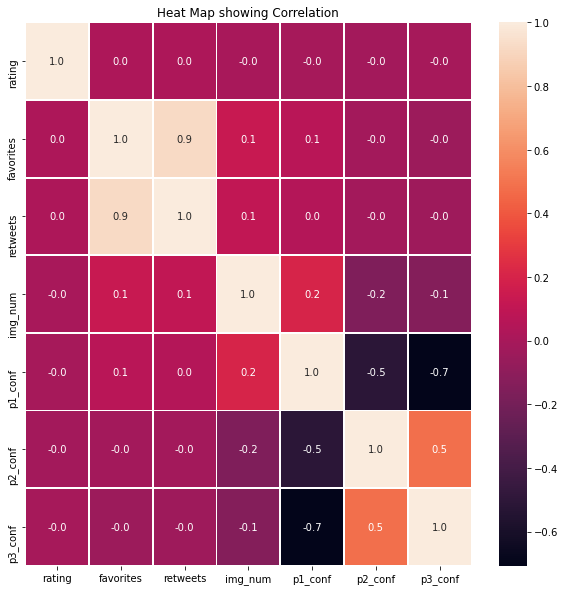

In [223]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(correlation, annot=True, linewidths=.8, fmt= '.1f',ax=ax)
plt.title('Heat Map showing Correlation')
plt.show()

* We the heat map above shows strong correlation between  favorites and retweets, negative correlation is seen between p1 and p3, and also between p1 and p2. 

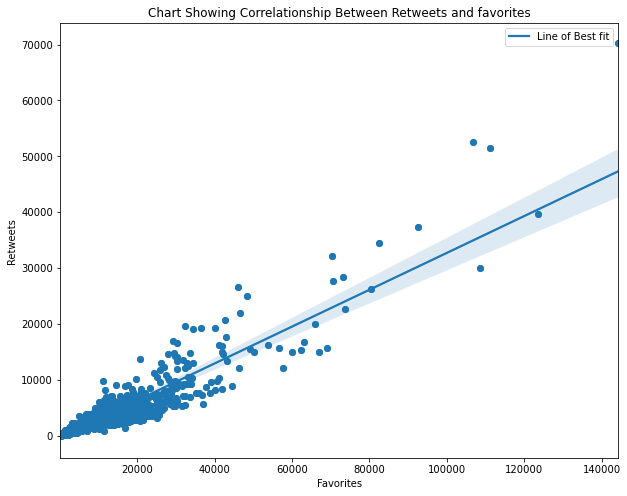

,favorites
retweets,
11.0,66.0
19.0,90.0
24.0,221.0
28.0,213.0
30.0,93.0
...,...
37270.0,92511.0
39762.0,123697.0
51436.0,111218.0


In [237]:
# Lets plot this relationship using a scatter plot
label = ['Line of Best fit']
plt.figure(figsize=(10,8))
plt.scatter(df_master_copy['favorites'], df_master_copy['retweets'])
sns.regplot(x='favorites', y='retweets', data=df_master_copy)
plt.xlabel('Favorites', size=10)
plt.ylabel('Retweets', size=10)
plt.title('Chart Showing Correlationship Between Retweets and favorites', size=12)
plt.legend(label)
plt.show()
df_master_copy.groupby(['retweets'])[['favorites']].sum()

* The scatter plot goes further to show the strong relation ship between favorite and retweet. As the values for favoites increase so do retweets, all moving towards the positive side of the chart, indication a strong positive correlation.

# What categories of Dog have the highest rating

,rating
dog_stages,
doggo,80
floofer,4
pupper,240
puppo,29


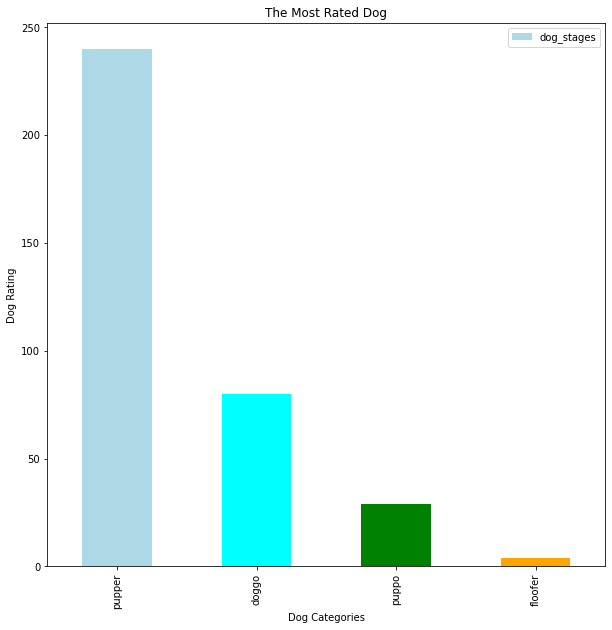

In [236]:
df_master_copy['dog_stages'].value_counts().plot(kind='bar',  color=['lightblue','cyan','green','orange'], figsize = (10,10)).set_ylabel('Dog Rating')
plt.xlabel('Dog Categories')
plt.legend(fontsize=10)
plt.title("The Most Rated Dog")
df_master_copy.groupby(['dog_stages'])[['rating']].count()

* The graph above shows that Pupper dog category has the highest rating with a score of 258.

# What Gender of Dog Dominated the Data set

,dog_sex
dog_sex,
NaN,844
female,231
male,1022


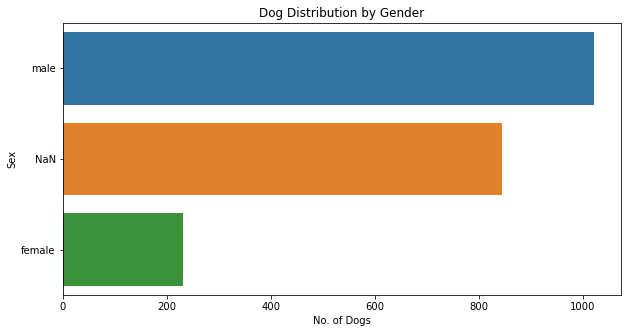

In [227]:
gender = df_master_copy['dog_sex'].value_counts().index
plt.figure(figsize=(10, 5))
sns.countplot(data=df_master_copy, y='dog_sex', order=gender)
plt.title('Dog Distribution by Gender')
plt.xlabel('No. of Dogs')
plt.ylabel('Sex');
df_master_copy.groupby(['dog_sex'])[['dog_sex']].count()

* Again, the graph above indicate that Male dogs dominated the dataset, with a good number of the gender not known.

# What Gender of Dog is Rated Most

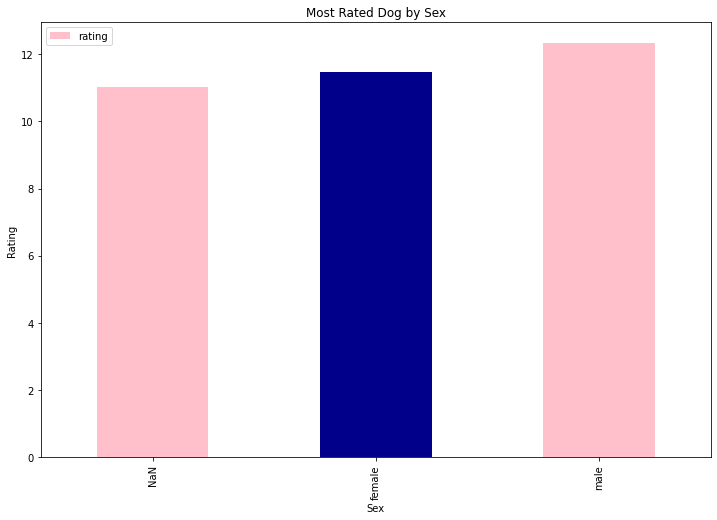

,rating
dog_sex,
NaN,11.010557
female,11.475427
male,12.327455


In [235]:
df_master_copy.groupby('dog_sex')['rating'].mean().plot(kind='bar', color=['#FFC0CB','#00008B','#FFC0CB'], figsize=(12,8));
plt.xlabel("Sex")
plt.ylabel("Rating")
plt.title("Most Rated Dog by Sex")
plt.legend()
plt.show()
df_master_copy.groupby(['dog_sex'])[['rating']].mean()

Male Dogs are slightly rated higher than their Female counter with and average rating of 12.3 to 11.4. Again we can see that a good number of the gender is unknown having score of 11.0 as well.

# What is the favourite Name for Dog 

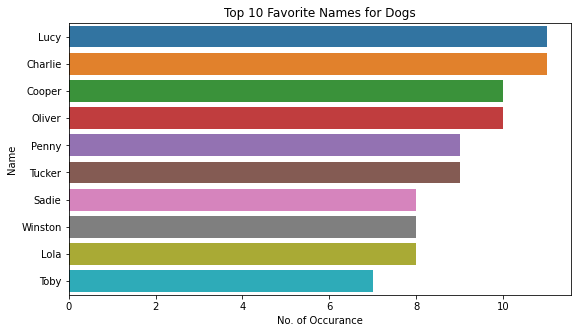

In [230]:
name = df_master_copy['name'].value_counts().head(10).index
plt.figure(figsize=(9, 5))
sns.countplot(data=df_master_copy, y='name', order=name)
plt.title('Top 10 Favorite Names for Dogs')
plt.xlabel('No. of Occurance')
plt.ylabel('Name');

* Charlie and Lucy are the favorite names for dogs.

# What image of Dog occure most in the distribution

In [231]:
df_master_copy.img_num.value_counts()

1.0    1692
2.0     190
3.0      59
4.0      30
Name: img_num, dtype: int64

,img_num
img_num,
1.0,1692
2.0,190
3.0,59
4.0,30


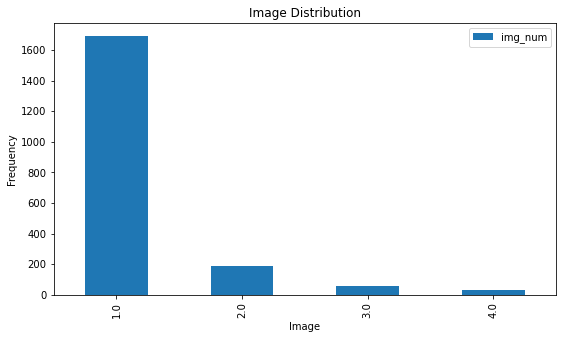

In [232]:
plt.figure(figsize=(9, 5))
df_master_copy['img_num'].value_counts().plot(kind='bar').set_ylabel('Frequency')
plt.xlabel('Image')
plt.legend()
plt.title('Image Distribution')
df_master_copy.groupby(['img_num'])[['img_num']].count()

* The Statistics above shows that the image appeared most at a confidence level of one. It goes further to show the excellent work done by the nueral network use for the prediction.

In [233]:
favorites = list(df_master_copy.favorites)
retweets = list(df_master_copy.retweets)
dtime = list(df_master_copy.timestamp)
df = pd.DataFrame(list(zip( favorites, retweets )),
				index = dtime,
				columns = [ 'favorites' , 'retweets' ])
df


,favorites,retweets
2017-08-01 16:23:56+00:,33698.0,6970.0
2017-08-01 00:17:27+00:,29228.0,5273.0
2017-07-31 00:18:03+00:,21976.0,3464.0
2017-07-30 15:58:51+00:,36793.0,7193.0
2017-07-29 16:00:24+00:,35184.0,7718.0
...,...,...
2015-11-16 00:24:50+00:,88.0,36.0
2015-11-16 00:04:52+00:,246.0,115.0
2015-11-15 23:21:54+00:,100.0,36.0
2015-11-15 23:05:30+00:,112.0,39.0


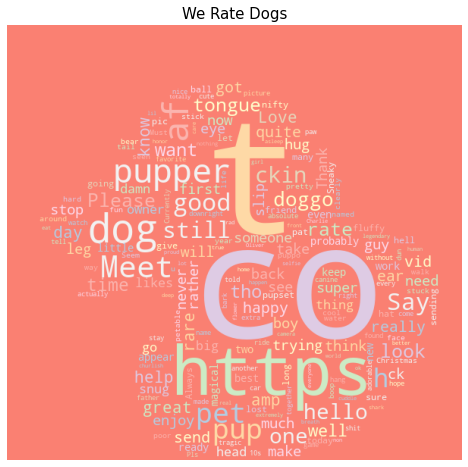

In [234]:
text = " ".join(df_master_copy['text'])
img_mask = np.array(Image.open("dog.jpg"))
img_colors = ImageColorGenerator(img_mask)
# Generate word cloud
word_cloud = WordCloud(
        width=3000,
        height=2000,
        mask=img_mask,
        random_state=1,
        background_color="salmon",
        colormap="Pastel1",
        collocations=False,
        stopwords=STOPWORDS,
        ).generate(text)
    # Display the generated Word Cloud with a Dog Image
plt.figure(figsize=(10, 8))    
plt.imshow(word_cloud)
plt.title('We Rate Dogs', size=15)
plt.axis("off")
plt.show()

<a id='reporting'></a>
## Reporting 

- Data wrangling efforts as contained in the wrangle_report.
- Data analyses and visualizations as contained in the act_report.


<a id='conclusions'></a>
## Conclusion
* Data collection from three sources was collected and analysed based on a WeRateDogs Twitter account that rates people's dogs with a humorous comment about the dog.
* Following the analysis perform on the data, some questions were ask to help us get insight, and is documented below:
### What categories of Dog have the highest rating?
* Pupper dog category had the highest rating with a score of 258.
### What Gender of Dog Dominated the Data set?
* Male dogs dominated the dataset, with a good number of the gender not known.
### What Gender of Dog is Rated Most?
* Female Dogs was observed to be slightly rated higher than their Male counter.
### What is the favourite Name for Dog?
* Dog name Charlie was the favorited name for dogs as shown in the analysis.
### What image of Dog occurred most in the distribution?
* The Statistics shown in our analysis shows that the image appeared most at a confidence level of 1.
## Recommendation
- The WeRateDog is a good source for data science project, and further research can be done in the predictive modelling of the dataset.